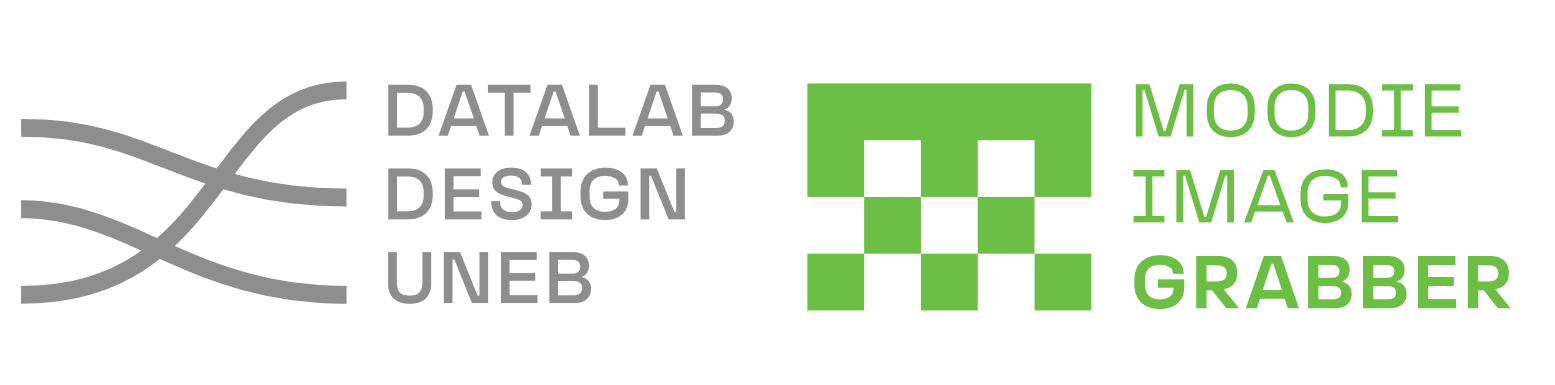

desenvolvido por [Elias Bitencourt](https://eliasbitencourt.com) | [Datalab Design](https://datalabdesign.org) - UNEB BAHIA BRASIL

#MOODIE IMAGE GRABBER - Módulo de Coleta de Imagens

MOODIE Grabber é o módulo de coleta de imagens da ferramenta [`MOODIE`](https://github.com/datalabdesign/moodie), desenvolvido para permitir o download massivo de imagens a partir de links, extração de metadados, renomeamento de arquivos e vinculação entre dataset com imagens e as imagens baixadas. Ele está em fase beta, sendo o primeiro módulo funcional da ferramenta MOODIE.

* *Para detalhes sobre a licença de uso veja [`LICENSE.txt`](https://github.com/datalabdesign/moodie/blob/main/LICENCE.txt).*

* **Como citar (formato APA):** Bitencourt, E. (2025). *MOODIE: Modular Observational & Operational Design Image Explorer Light - Módulo Grabber* (Versão beta) [Repositório GitHub]. Datalab/Design – Universidade do Estado da Bahia. https://github.com/datalabdesign/moodie

In [ ]:
# @title #01 Instalando as dependências para o MOODIE
import ipywidgets as widgets
from IPython.display import display, clear_output
import subprocess, sys, importlib.util, time, base64
import time
from io import BytesIO
from PIL import Image
import re
import pandas as pd

def _already_installed(pkg: str) -> bool:
    """Retorna True se o pacote já estiver presente no ambiente."""
    return importlib.util.find_spec(pkg) is not None

# FUnção auxiliar.. garante que teremos diretório mesmo se o usuário pular o modulo do diretório
def ensure_project_dir():
    """
    Garante que:
      • project_dir exista com todas as subpastas-padrão;
      • project_name esteja definido (fallback: 'moodie_temp').
    """
    global project_dir, project_name

    # Cria project_dir se não existir
    if 'project_dir' not in globals():
        project_dir = os.path.join(os.getcwd(), 'MOODIE_temp')
        print(f"[MOODIE] 'project_dir' não estava definido; usando {project_dir}")

    # Cria subpastas padrão
    for sd in ["datasets", "reports", "imagens", "imagewall", "paleta"]:
        os.makedirs(os.path.join(project_dir, sd), exist_ok=True)

    # Garante project_name
    if 'project_name' not in globals() or not project_name:
        project_name = "moodie_temp"

#instalação silenciosa de pacotes para não assustar estudantes
def install_dependencies(button):
    with output:
        clear_output()
        progress_bar = widgets.IntProgress(value=0, min=0, max=7, description="Instalando...")
        display(progress_bar)
        print("Instalando tudo que você precisa para usar o MOODIE... Espera só um pouquinho.")

        # Cada pacote é informado em uma posição da lista
        dependencies = [
            "imagehash",
            "colorthief",
            "pillow",
            "umap-learn",
            "hdbscan",
            "distinctipy",
            "bokeh",
            "ijson"
        ]

        for i, dependency in enumerate(dependencies):
            try:
                subprocess.check_call(["pip", "install", dependency], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                progress_bar.value = i + 1
                time.sleep(1)  # Simula o tempo de instalação
            except subprocess.CalledProcessError as e:
                clear_output()
                print(f"Erro ao instalar {dependency}. Tentando novamente...")
                try:
                    subprocess.check_call(["pip", "install", "--no-cache-dir", dependency], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                    progress_bar.value = i + 1
                    time.sleep(1)
                except subprocess.CalledProcessError as e:
                    clear_output()
                    print(f"Erro ao instalar {dependency}.")
                    print("Verifique sua conexão ou tente novamente mais tarde.")
                    return

        clear_output()
        print("Instalação concluída com sucesso!")

install_button = widgets.Button(description="Instalar")
output = widgets.Output()

install_button.on_click(install_dependencies)

display(install_button, output)


In [ ]:
# @title #02 Conectando ao Google Drive
#@markdown O MOODIE funciona melhor se você estiver conectado ao seu google drive.
#@markdown Isso evita que arquivos muito pesados tornem o processo ainda mais lento.
#@markdown Mas, se você preferir trabalhar com os arquivos fazendo upload, também é uma opção.
#@markdown É só seguir para o módulo 03.

import os
import ipywidgets as widgets
from IPython.display import display, clear_output

# Seção 1: Conexão com Google Drive
# Flag global para indicar se o Drive foi conectado
drive_connected = False # garante existência da flag mesmo se bloco #02 não for executado

# Área de saída para a conexão
connect_output = widgets.Output()

def on_connect_clicked(b):
    global drive_connected
    with connect_output:
        clear_output()
        if importlib.util.find_spec("google.colab") is None:
            print("Este notebook não está rodando no Google Colab. Pule esta etapa.")
            return
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            drive_connected = True
            print("Google Drive conectado com sucesso.")
            # Atualiza o botão para indicar que a conexão foi realizada
            connect_button.description = "Google Drive Conectado"
            connect_button.disabled = True
        except Exception as e:
            print("Erro ao conectar o Google Drive:", e)

# Botão para conectar ao Google Drive
connect_button = widgets.Button(
    description="Conectar ao Google Drive",
    layout=widgets.Layout(width='300px')
)
connect_button.on_click(on_connect_clicked)

# Exibe a interface de conexão
display(widgets.VBox([connect_button, connect_output]))

In [ ]:
# @title #03 Criando diretórios de trabalho
#@markdown Agora vamos começar a organizar nosso ambiente de trabalho!
#@markdown 1. Se você já se conectou ao google drive, Marque SIM. Se prefere trabalhar fazendo uploads, marque NÃO.
#@markdown 2. Se você já tem uma pasta no seu drive ou no amnbiente do google colab, marque a opção "Diretório Existente". Mas se quiser começar um novo projeto, marque "Novo Diretório"
#@markdown 3. Se você marcou "Novo diretório", basta informar o nome da pasta onde você quer salvar os trabalhos e indicar o caminho dessa pasta.
#@markdown    - Se você está conectado ao google drive, cole o caminho da sua pasta. Você pode visualizar o caminho abrindo o menu lateral à sua esquerda selecionando o ícone da pasta (files), depois procurando pela pasta Drive. No menu dropdown dessa pasta vc verá a árvore dos seus arquivos no google drive. Basta procurar o diretório desejado, clicar com o botão direito do mouse e selecionar "copiar path".
#@markdown    - Se você deseja usar algum diretório que já está no seu ambiente colab, o processo é o mesmo. Basta procurar pela sua pasta na lateral esquerda e repetir o processo.
#@markdown    - Se optar por deixar esse campo em branco, o MOODIE vai criar uma pasta com o nome desejado no seu drive, se estiver conectado, ou no ambiente do colab.

#@markdown 4. Agora digite o nome do seu projeto. Ele será usado para customizar os nomes dos arquivos que o MOODIE vai salvar pra você.
#@markdown 5. Escreva uma nota mental sobre o que é o seu projeto e outra informação que você achar importante. O MOODIE vai salvar um arquivo de registro com todas as informações organizadas para facilitar a sua navegação posterior
# Widget que pergunta se você está conectado ao Google Drive.
# Caso o botão de conexão tenha sido clicado, o padrão será "Sim".

if 'drive_connected' not in globals():
    drive_connected = False


#widgets interface

default_connected = 'Sim' if drive_connected else 'Não'
connection_status = widgets.RadioButtons(
    options=['Sim', 'Não'],
    value=default_connected,
    description='Está conectado ao Google Drive?',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '220px'}
)

# Widget para escolha entre criar um novo diretório ou usar um existente.
directory_choice = widgets.RadioButtons(
    options=['Novo diretório', 'Diretório existente'],
    value='Novo diretório',
    description='Opção:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

# Widgets para quando for criar um novo diretório.
folder_input = widgets.Text(
    value='',
    placeholder='Digite o nome da nova pasta',
    description='Nome da Pasta:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

specific_path_input = widgets.Text(
    value='',
    placeholder='Opcional: caminho específico onde criar a pasta',
    description='Caminho específico:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

# Widget para quando for utilizar um diretório existente.
existing_folder_input = widgets.Text(
    value='',
    placeholder='Digite o caminho do diretório existente',
    description='Diretório existente:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

# Widgets para os dados do projeto.
project_name_input = widgets.Text(
    value='',
    placeholder='Digite o nome do projeto',
    description='Nome do Projeto:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

project_description_input = widgets.Textarea(
    value='',
    placeholder='Digite uma breve descrição do projeto',
    description='Descrição do Projeto:',
    layout=widgets.Layout(width='600px', height='150px'),
    style={'description_width': '150px'}
)

# Botão para confirmar as escolhas.
confirm_button = widgets.Button(
    description='Confirmar'
)

# Área de saída para exibir mensagens da criação dos diretórios.
dir_output = widgets.Output()

# Atualiza os campos exibidos conforme a escolha entre novo diretório ou diretório existente.
def update_directory_fields(change):
    if change['new'] == 'Novo diretório':
        folder_input.layout.display = ''
        specific_path_input.layout.display = ''
        existing_folder_input.layout.display = 'none'
    else:
        folder_input.layout.display = 'none'
        specific_path_input.layout.display = 'none'
        existing_folder_input.layout.display = ''

directory_choice.observe(update_directory_fields, names='value')
update_directory_fields({'new': directory_choice.value})

# Função que processa as informações e cria (ou utiliza) o diretório com a estrutura do projeto.
def on_confirm_clicked(b):
    global project_name, project_dir  # Variáveis globais para uso posterior na pipeline
    with dir_output:
        clear_output()
        # Define o caminho base dependendo da opção selecionada na segunda interface.
        if connection_status.value == 'Sim':
            base_path = '/content/drive/My Drive'
        else:
            base_path = '/content'

        # Seleciona o diretório do projeto conforme a escolha do usuário.
        if directory_choice.value == 'Novo diretório':
            folder_name = folder_input.value.strip()
            if folder_name == '':
                print("Por favor, informe o nome da nova pasta.")
                return
            specific_path = specific_path_input.value.strip()
            if specific_path:
                if not specific_path.startswith('/'):
                    specific_path = os.path.join(base_path, specific_path)
                new_base = specific_path
            else:
                new_base = base_path
            project_folder = os.path.join(new_base, folder_name)
            if not os.path.exists(project_folder):
                os.makedirs(project_folder)
                print(f"Pasta principal criada: {project_folder}")
            else:
                print(f"Pasta principal já existe: {project_folder}")
        else:  # Caso utilize diretório existente.
            project_folder = existing_folder_input.value.strip()
            if project_folder == '':
                print("Por favor, informe o caminho do diretório existente.")
                return
            if not os.path.exists(project_folder):
                print(f"O diretório especificado não existe: {project_folder}")
                return
            print(f"Utilizando diretório existente: {project_folder}")

        # Coleta os dados do projeto.
        project_name = project_name_input.value.strip()
        project_description = project_description_input.value.strip()

        # Cria os subdiretórios necessários.
        subdirs = {
            "datasets": "Local onde os datasets em csv serão salvos",
            "reports": "Local onde os relatórios e documentações dos processamentos serão salvos",
            "imagens": "Local onde as imagens baixadas ficam armazenadas",
            "imagewall": "Local onde as visualizações de dados das imagewals ficam armazenadas",
            "paleta": "Local onde as paletas de cores extraídas do dataset serão salvas",
            #"clusters": "Local onde os arquivos e visualizações dos clusters são armazenados"
        }

        for subdir in subdirs.keys():
            path_subdir = os.path.join(project_folder, subdir)
            if not os.path.exists(path_subdir):
                os.makedirs(path_subdir)

        # Monta a estrutura do projeto em formato de string.
        tree_str = (
            f"Nome do Projeto: {project_name}\n\n"
            f"Descrição do Projeto: {project_description}\n\n"
            f"Estrutura da árvore de arquivos:\n\n"
            f"{project_folder}\n"
        )
        for subdir, desc in subdirs.items():
            tree_str += f"├── {subdir}  ---> {desc}\n"
        tree_str += "\nOBS: no módulo das imagewals é possível gerar paleta de cores por clusters.\n"
        tree_str += "As imagens serão salvas dentro de subdiretórios da pasta imagewall.\n\n"
        tree_str += ("OBS 2: para facilitar a diferenciação e documentação do processo, "
                     "os arquivos importantes são salvos com registro de tempo ao final no formato "
                     "DD_MM_AA_HH_MM (Dia_Mês_Ano_Hora_Minuto).\n")

        print(tree_str)

        # Salva um arquivo README com a estrutura do projeto.
        readme_path = os.path.join(project_folder, f"Readme_first_{project_name}.txt")
        try:
            with open(readme_path, "w") as f:
                f.write(tree_str)
            print(f"Readme salvo em: {readme_path}")
        except Exception as e:
            print("Erro ao salvar o Readme:", e)

        project_dir = project_folder
        print("Este diretório será utilizado para salvar os arquivos do projeto.")

confirm_button.on_click(on_confirm_clicked)

# Exibe a segunda interface
display(widgets.VBox([
    connection_status,
    directory_choice,
    folder_input,
    specific_path_input,
    existing_folder_input,
    project_name_input,
    project_description_input,
    confirm_button,
    dir_output
]))


In [ ]:
# @title #04 UPLOAD E ANÁLISE DO CSV ou JSON (obrigatório)
#UPDATE 08.05.2025
# - implementa compatibilidade com json

#@markdown Neste módulo você fará o upload de um arquivo CSV ou JSON
#@markdown Após o upload, o código:
#@markdown  Lê o arquivo e o armazena em um DataFrame (variável global para uso posterior);
#@markdown - Exibe a lista de colunas presentes;
#@markdown - Mostra o número total de linhas;
#@markdown - Identifica e informa quais colunas possuem valores NaN e quantos NaNs há em cada;
#@markdown - Exibe os tipos de dados de cada coluna;
#@markdown - Analisa quais colunas possuem valores únicos e, para cada uma delas, simula quantas duplicatas seriam removidas se fossem usadas como identificador único.

import os, io, time, json, re
import pandas as pd
from pandas import json_normalize
import ipywidgets as widgets
from IPython.display import display, clear_output

# ---------- Utilidades ----------
def get_timestamp():
    return time.strftime("%d_%m_%y_%H_%M")

def _flatten_lists(df, sep="|"):
    """Converte colunas que contenham listas em strings separadas por `sep`."""
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, list)).any():
            df[col] = df[col].apply(
                lambda x: sep.join(map(str, x)) if isinstance(x, list) else x
            )
    return df

def load_to_dataframe(source):
    """
    Recebe um BytesIO ou caminho para arquivo .csv/.json.
    Detecta o formato e devolve DataFrame “flattenado”.
    Mostra barra de progresso (se existir a variável global
    `processing_progress`) para JSONs grandes.
    Levanta ValueError com mensagem amigável se quebrar.
    """
    is_buffer = isinstance(source, io.BytesIO)
    prog = globals().get("processing_progress", None)

    # ---- detecção por extensão ou primeiros bytes ----
    if is_buffer:
        hdr = source.getvalue()[:20].lstrip()
        is_json = hdr.startswith(b"{") or hdr.startswith(b"[")
        src_size = len(source.getvalue())
    else:
        is_json = str(source).lower().endswith(".json")
        src_size = os.path.getsize(source) if is_json else 0

    try:
        #  CSV
        if not is_json:
            return pd.read_csv(source)

        # JSON
        # carrega inteiro se arquivo < 10 MB
        if src_size < 10 * 1024 * 1024:
            obj = json.load(source) if is_buffer else json.load(
                open(source, "r", encoding="utf-8")
            )
        else:
            # STREAMING com ijson
            import ijson
            if prog is not None:
                prog.description, prog.value = "Lendo JSON:", 0
                prog.bar_style, prog.layout.display = "info", "flex"

            # 1ª passada: contar itens para estimar progresso
            with (io.BytesIO(source.getvalue()) if is_buffer else open(source, "rb")) as f_cnt:  # NEW
                total_items = sum(1 for _ in ijson.items(f_cnt, "item"))

            # 2ª passada: ler efetivamente
            items, step = [], max(1, total_items // 80)
            with (io.BytesIO(source.getvalue()) if is_buffer else open(source, "rb")) as f:
                for idx, itm in enumerate(ijson.items(f, "item"), 1):
                    items.append(itm)
                    if prog and idx % step == 0:
                        prog.value = min(80, int(idx / total_items * 80))
            obj = items
            if prog: prog.value = 80


        # 1) Identifica lista principal a virar linhas  (mesmo código)

        if isinstance(obj, list):
            base = obj
        elif isinstance(obj, dict):
            base = next((v for v in obj.values() if isinstance(v, list)), None)
            if base is None:
                raise ValueError("Não encontrei lista principal no JSON para converter em linhas.")
        else:
            raise ValueError("Estrutura JSON não suportada.")

        # 2) Normaliza + achata
        df = json_normalize(base, sep="_")
        df = _flatten_lists(df)                                  #

    except (json.JSONDecodeError, UnicodeDecodeError) as e:
        raise ValueError(f"Erro ao decodificar JSON: {e}")
    except pd.errors.ParserError as e:
        raise ValueError(f"Erro ao ler CSV: {e}")

    # Pequena limpeza extra
    df.columns = [c.strip() for c in df.columns]

    if prog:
        prog.value = 100

    return df

#  Widgets de interface
method_choice = widgets.RadioButtons(
    options=["Upload", "Fornecer caminho"],
    value="Upload",
    description="Método:",
    layout=widgets.Layout(width='11,5%'),
    style={"description_width": "initial"},
)

upload_widget = widgets.FileUpload(
    accept=".csv,.json", multiple=False, layout=widgets.Layout(width="11,5%")
)

file_path_input = widgets.Text(
    value="",
    placeholder="caminho/arquivo.{csv|json}",
    description="Arquivo local:",
    layout=widgets.Layout(width="80%"),
    style={"description_width": "initial"},
)
file_path_input.layout.display = "none"  # esconde no início

upload_progress = widgets.IntProgress(
    value=0, min=0, max=100, description="Upload:", bar_style="warning"
)
upload_progress.layout.display = "none"

processing_progress = widgets.IntProgress(
    value=0, min=0, max=100, description="Processando:", bar_style="info"
)
processing_progress.layout.display = "none"

output_upload = widgets.Output()
container = widgets.VBox([upload_progress, processing_progress, output_upload])

def _toggle_fields(change):
    up = change["new"] == "Upload"
    upload_widget.layout.display = "" if up else "none"
    file_path_input.layout.display = "none" if up else ""
method_choice.observe(_toggle_fields, names="value")
_toggle_fields({"new": method_choice.value})  # init


# ---------- Análise ----------
def analyze_file(_):
    with output_upload:
        clear_output()
        ensure_project_dir()  # garante estrutura completa
        # 1) pegar o arquivo --------------------------------------------------
        if method_choice.value == "Upload":
            if not upload_widget.value:
                print("Nenhum arquivo enviado."); return
            upload_progress.layout.display = "flex"
            upload_progress.value = 100
            source = io.BytesIO(list(upload_widget.value.values())[0]["content"])
        else:
            path = file_path_input.value.strip()
            if not path or not os.path.exists(path):
                print("Caminho inválido ou inexistente."); return
            source = path

        # 2) carregar em DataFrame -------------------------------------------
        processing_progress.layout.display = "flex"
        processing_progress.value = 25
        try:
            df = load_to_dataframe(source)
        except ValueError as err:
            print(err); return
        processing_progress.value = 60

        # 3) relatório – exatamente como no código original ------------------
        global global_df
        global_df = df.copy()

        print("Relatório de análise do CSV/JSON:")

        # --- colunas --------------------------------------------------------
        print("\nColunas encontradas:")
        print(df.columns.tolist())

        # --- tamanho --------------------------------------------------------
        print(f"\nNúmero de linhas: {df.shape[0]}")

        # --- NaNs -----------------------------------------------------------
        nan_counts = df.isna().sum()
        colunas_com_nan = nan_counts[nan_counts > 0]
        print("\nColunas com valores NaN e quantidade de NaNs:")
        if colunas_com_nan.empty:
            print("Nenhuma coluna possui valores NaN.")
        else:
            for col, ct in colunas_com_nan.items():
                print(f"{col}: {ct}")
            print(f"\nTotal de colunas com NaN: {len(colunas_com_nan)}")

        # --- dtypes ---------------------------------------------------------
        print("\nTipos de dados das colunas:")
        print(df.dtypes)

        # --- identificadores ------------------------------------------------
        print("\nAnálise de possíveis identificadores (apenas colunas com taxa de unicidade >= 65%):")
        total_count = df.shape[0]
        columns_info = []

        for col in df.columns:
            series = df[col]
            # trata strings vazias ou NaN
            if series.dtype == object:
                valid_series = series.dropna()
                valid_series = valid_series[valid_series.str.strip() != ""]
            else:
                valid_series = series.dropna()

            valid_count = valid_series.shape[0]
            if valid_count == 0:
                continue
            unique_count = valid_series.nunique()
            ratio = unique_count / valid_count
            missing_note = ""
            if valid_count < total_count:
                missing_note = " (Observação: valores vazios/NaN foram ignorados)"
            if ratio >= 0.65:
                duplicates_removed = valid_count - unique_count
                columns_info.append(
                    (col, ratio, unique_count, duplicates_removed, df[col].dtype, missing_note)
                )

        # ordena pela maior unicidade
        columns_info.sort(key=lambda x: x[1], reverse=True)

        for col, ratio, unique_count, duplicates_removed, col_dtype, note in columns_info:
            print(f"Coluna '{col}':")
            print(f"  Tipo: {col_dtype}")
            print(f"  Unicidade: {unique_count} de {df[col].dropna().shape[0]} ({ratio:.2%}){note}")
            print(f"  Duplicatas removidas se usada como chave: {duplicates_removed}\n")

        # 4) salvar CSV normalizado -----------------------------------------
        base_dir = globals().get("project_dir", os.getcwd())
        os.makedirs(os.path.join(base_dir, "datasets"), exist_ok=True)
        proj = globals().get("project_name", "projeto")
        out_path = os.path.join(
            base_dir, "datasets", f"dataset_{proj}_upload_{get_timestamp()}.csv"
        )
        df.to_csv(out_path, index=False)
        processing_progress.value = 100

        print(f"Dataset salvo em: {out_path}")


# ---------- Botão ----------
analyze_button = widgets.Button(
    description="Analisar", button_style="success"
)
analyze_button.on_click(analyze_file)

# ---------- Exibe interface ----------
display(
    widgets.VBox(
        [
            widgets.Label("Selecione como fornecer o arquivo (CSV ou JSON):"),
            method_choice,
            upload_widget,
            file_path_input,
            analyze_button,
            container,
        ]
    )
)


In [ ]:
# @title #05 Remoção de duplicatas (opcional)
#@markdown Se você olhou direitinho o relatório do módulo anterior, já deve ter observado que algumas colunas podem ajudar você a remover eventuais duplicatas na sua base. Observe com cuidado e veja se alguma delas pode ser útil. Mas tenha em mente:
#@markdown  - Só delete duplicatas se você já inspecionou a sua base de dados antes e tem certeza que isso será necessário. Ou que a estrutura dos seus dados não induzirá à remoção inadequada. Em alguns casos, sua base pode ter muitas imagens repetidas por se tratar de um meme ou algo viral. Se você remove, irá perder essa nuance. Escolha com cuidado aquilo que melhor atende aos seus objetivos.
#@markdown  - Uma vez removidas, Puft! já era. Se quiser acessar os dados originais, você vai ter que fazer o upload do seu CSV original, novamente. Então, é sempre bom ter uma cópia.
#@markdown  - Se não há o que remover, vida que segue. Vamos para o próximo passo!
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import time
import os

# Widget para informar as colunas para remoção de duplicatas
help_text = widgets.Label(
    "Indique a(s) coluna(s) de referência para remoção de duplicatas (ex: ColunaA, ColunaB)."
)

dup_columns_input = widgets.Text(
    value='',
    placeholder='Ex: ColunaA, ColunaB',
    description='Coluna:',
    #layout=widgets.Layout(width='600px'),
    style={'description_width': '150px'}
)

# Botão para confirmar a remoção
dup_button = widgets.Button(
    description='Remover duplicatas'
)

# Área de saída para exibir o relatório
output_dup = widgets.Output()

# Barra de progresso para feedback do processo
progress_removal = widgets.IntProgress(value=0, min=0, max=100, description='Progresso:', bar_style='info')

# Container que agrupa a barra de progresso e a área de saída
container_dup = widgets.VBox([progress_removal, output_dup])

def remove_duplicates_ignore_na_blank(df, dup_cols):
    """
    Remove duplicatas considerando apenas as linhas que possuam valores válidos (não-nulos, não-vazios)
    em todas as colunas de dup_cols. Linhas com valores nulos ou em branco nessas colunas são mantidas
    sem alteração (não são consideradas duplicadas).
    """
    valid_mask = pd.Series([True] * len(df), index=df.index)
    for c in dup_cols:
        if pd.api.types.is_object_dtype(df[c]):
            # Se for coluna do tipo object, considera nulo ou string vazia como inválido
            valid_mask &= df[c].notna() & (df[c].str.strip() != "")
        else:
            # Se for coluna numérica ou outro tipo, apenas checa se não é NaN
            valid_mask &= df[c].notna()

    df_valid = df[valid_mask].copy()
    df_invalid = df[~valid_mask].copy()

    # Remove duplicatas apenas no df_valid
    df_valid_dedup = df_valid.drop_duplicates(subset=dup_cols)

    # Combina novamente
    df_dedup = pd.concat([df_invalid, df_valid_dedup], ignore_index=True)
    return df_dedup

def get_timestamp():
    """Retorna um timestamp no formato DD_MM_YY_HH_MM."""
    return time.strftime("%d_%m_%y_%H_%M")


def on_dup_clicked(b):
    with output_dup:
        clear_output()
        progress_removal.value = 0

        # Verifica se o DataFrame global foi definido
        try:
            global global_df
        except NameError:
            print("DataFrame não encontrado. Faça o upload e análise do CSV primeiro (Módulo 2).")
            return

        # Lê as colunas de duplicatas
        dup_cols = [col.strip() for col in dup_columns_input.value.split(',') if col.strip() != '']
        if not dup_cols:
            print("Por favor, insira ao menos uma coluna para remoção de duplicatas.")
            return

        # Verifica se as colunas informadas existem no DataFrame
        missing_dup = [col for col in dup_cols if col not in global_df.columns]
        if missing_dup:
            print(f"As seguintes colunas para remoção não foram encontradas: {missing_dup}")
            return

        progress_removal.value = 20
        time.sleep(0.2)

        # Remove duplicatas sem descartar linhas com NaN ou strings vazias
        original_count = global_df.shape[0]
        df_dedup = remove_duplicates_ignore_na_blank(global_df, dup_cols)
        new_count = df_dedup.shape[0]
        duplicates_removed = original_count - new_count
        percent_removed = (duplicates_removed / original_count) * 100

        # Atualiza o DataFrame global
        global_df = df_dedup.copy()

        # Linha adicionada: Criação da pasta "datasets" e salvamento do dataset sem duplicatas
        # Usa o diretório base definido (project_dir se existir, caso contrário o diretório atual)
        base_dir = globals().get("project_dir", os.getcwd()) # Se project_dir estiver definido, usa-o; senão, usa o cwd
        datasets_dir = os.path.join(base_dir, "datasets")
        if not os.path.exists(datasets_dir):
            os.makedirs(datasets_dir)
        dataset_filename = f"dataset_{project_name}_no_duplicate_{get_timestamp()}.csv"
        dataset_path = os.path.join(datasets_dir, dataset_filename)
        df_dedup.to_csv(dataset_path, index=False)
        print(f"Dataset sem duplicatas salvo em: {dataset_path}")
        # Fim da linha adicionada

        progress_removal.value = 60
        time.sleep(0.2)

        # Gera relatório
        report_text = "Relatório de remoção de duplicatas:\n"
        report_text += f"Número original de linhas: {original_count}\n"
        report_text += f"Número de linhas após remoção: {new_count}\n"
        report_text += f"Duplica(s) removida(s): {duplicates_removed}\n"
        report_text += f"Percentual removido: {percent_removed:.2f}%\n"
        report_text += f"Colunas usadas para remoção: {dup_cols}\n"

        progress_removal.value = 100

        # Salva o relatório em arquivo TXT
        reports_dir = os.path.join(base_dir, "reports")  # Linha adicionada para salvar de acordo com a árvore
        if not os.path.exists(reports_dir):
            os.makedirs(reports_dir)  # Linha adicionada
        report_filename = f"report_remocao_duplicatas_{project_name}.txt"
        if 'project_dir' in globals():
            report_path = os.path.join(reports_dir, report_filename)
        else:
            report_path = report_filename

        with open(report_path, "w") as f:
            f.write(report_text)

        print(report_text)

dup_button.on_click(on_dup_clicked)

display(widgets.VBox([help_text, dup_columns_input, dup_button, container_dup]))


In [ ]:
# @title #06 Sampleamento de dataset (opcional)
#(preciso remover a linha que salva o sampleado como global para evitar problemas com os testes... na parte do download o usuário vai precisar subir o arquivo com o dataset sampleado, caso contrário, ele segue com o dataset que já foi aberto)
# Interface de Amostragem com integração ao DataFrame global_df
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import time
import warnings
from math import sqrt, log2

# Interface widgets
analyze_button = widgets.Button(
    description='Analisar',
    button_style='info',
    layout=widgets.Layout(width='300px')
)

sampling_method_widget = widgets.Dropdown(
    options=['Downsample', 'Upsample', 'Random Sample'],
    value='Downsample',
    description='Método:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

category_column_widget = widgets.Text(
    description='Coluna categoria:',
    placeholder='Ex: classe, categoria, grupo...',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

sample_size_widget = widgets.IntText(
    value=100,
    description='Total linhas:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

run_button = widgets.Button(
    description='Executar',
    button_style='success',
    layout=widgets.Layout(width='300px')
)

output = widgets.Output()
latest_analysis = ""

# Funções auxiliares
def sample_data(df, method, category_column, n_total):
    if category_column and category_column in df.columns:
        grouped = df.groupby(category_column)
        if method == 'Downsample':
            min_size = grouped.size().min()
            sampled_df = grouped.apply(lambda x: x.sample(n=min(min_size, n_total // grouped.ngroups), random_state=1)).reset_index(drop=True)
        elif method == 'Upsample':
            sampled_df = grouped.apply(lambda x: x.sample(n=n_total // grouped.ngroups, replace=True, random_state=1)).reset_index(drop=True)
        elif method == 'Random Sample':
            sampled_df = df.sample(n=min(n_total, len(df)), random_state=1).reset_index(drop=True)
    else:
        sampled_df = df.sample(n=min(n_total, len(df)), random_state=1).reset_index(drop=True)
    return sampled_df

def representativity(original, sampled):
    return round(len(sampled) / len(original) * 100, 2)

def confidence_interval(n_population, n_sample, confidence_level=0.95):
    p = 0.5
    z = 1.96 if confidence_level == 0.95 else 1.64
    e = z * sqrt((p * (1 - p)) / n_sample) * sqrt((n_population - n_sample) / (n_population - 1))
    return round(e * 100, 2)

def get_timestamp():
    return time.strftime("%d_%m_%y_%H_%M")

def analyze_dataframe(df):
    global latest_analysis
    analysis_report = []
    print("Análise exploratória de colunas categóricas:")
    candidate_columns = []
    for col in df.select_dtypes(include='object').columns:
        sample_vals = df[col].dropna().astype(str).sample(min(100, len(df[col].dropna())), random_state=1)
        if sample_vals.str.contains('http|www|\.com|@').any():
            continue
        if sample_vals.str.contains(',|;').any():
            continue
        if sample_vals.str.len().mean() > 50:
            continue
        nunique = df[col].nunique()
        if nunique > 1 and nunique < len(df) * 0.5:
            candidate_columns.append((col, nunique))

    if not candidate_columns:
        print("Nenhuma coluna categórica adequada encontrada.")
        return

    print(f"Colunas categóricas identificadas: {len(candidate_columns)}\n")
    for col, n_cat in candidate_columns:
        dist = df[col].value_counts(normalize=True)
        max_ratio = dist.max()
        entropy = -np.sum(dist * np.log2(dist))
        max_entropy = round(log2(n_cat), 4)
        norm_entropy = round(entropy / max_entropy, 4)

        if max_ratio > 0.8:
            recommendation = "Downsample recomendado para evitar viés da classe dominante."
        elif norm_entropy > 0.85:
            recommendation = "Random Sample adequado devido à boa distribuição."
        else:
            recommendation = "Upsample recomendado para compensar desequilíbrio moderado."

        dual_option = (
            f"Use Downsample se desejar garantir igualdade entre grupos (mesmo tamanho para cada categoria).\n"
            f"Use Upsample se quiser manter todas as categorias e reforçar as minoritárias."
        ) if 'Upsample' in recommendation or 'Downsample' in recommendation else (
            "Use Random Sample se desejar refletir a proporção original das categorias.\n"
            "Use Upsample se quiser uma amostra mais equilibrada para comparação entre grupos."
        )

        info = f"""
Coluna: {col}
- Nº Categorias: {n_cat}
- Entropia: {round(entropy, 4)} / Máxima possível: {max_entropy}
- Entropia Normalizada: {norm_entropy}
- Categoria dominante: {round(max_ratio*100, 2)}%
- Recomendação principal: {recommendation}
{dual_option}
"""
        print(info)
        analysis_report.append(info)

    print("""
Critérios:
- URLs, textos longos e listas são excluídos.
- Entropia (diversidade) e proporção da maior categoria são analisadas para sugestão de amostragem.
""")
    latest_analysis = "\n".join(analysis_report)

# Callback do botão de execução
def on_run_clicked(b):
    with output:
        clear_output()
        warnings.simplefilter(action='ignore', category=DeprecationWarning)
        try:
            global global_df
        except NameError:
            print("DataFrame global (global_df) não encontrado. Verifique se ele foi carregado.")
            return

        df = global_df.copy()
        method = sampling_method_widget.value
        category_col = category_column_widget.value.strip()
        n_total = sample_size_widget.value

        if method in ['Downsample', 'Upsample'] and (not category_col or category_col not in df.columns):
            print(f"Atenção: o método '{method}' requer uma coluna de categoria válida. Mudando para 'Random Sample'.")
            method = 'Random Sample'

        sampled_df = sample_data(df, method, category_col, n_total)
        rep = representativity(df, sampled_df)
        ci = confidence_interval(len(df), len(sampled_df))

        base_dir = globals().get("project_dir", os.getcwd())
        timestamp = get_timestamp()
        reports_dir = os.path.join(base_dir, "reports")
        if not os.path.exists(reports_dir):
            os.makedirs(reports_dir)

        print(f"Tamanho final da amostra: {len(sampled_df)} linhas")
        print(f"Representatividade: {rep}% do corpus original")
        print(f"Margem de erro estimada (95%): ±{ci}%")

        if category_col and category_col in df.columns:
            dist_orig = df[category_col].value_counts(normalize=True) * 100
            dist_sample = sampled_df[category_col].value_counts(normalize=True) * 100
            abs_sample = sampled_df[category_col].value_counts()
            abs_original = df[category_col].value_counts()
            categories = df[category_col].value_counts().index
            summary = pd.DataFrame({
                'Categoria': categories,
                'Linhas no original': abs_original[categories].astype(int),
                '% no original': dist_orig[categories].round(2),
                '% na amostra': dist_sample.reindex(categories).fillna(0).round(2),
                'Total na amostra': abs_sample.reindex(categories).fillna(0).astype(int)
            })
            display(summary)

            fig, ax = plt.subplots(figsize=(10, 5))
            dist_orig.sort_index().plot(kind='bar', alpha=0.5, label='Original', ax=ax, edgecolor='none')
            dist_sample.sort_index().plot(kind='bar', alpha=0.7, label='Amostrado', ax=ax, edgecolor='none')
            ax.set_frame_on(False)
            ax.legend(frameon=False)
            plt.title('Distribuição por Categoria')
            plt.tight_layout()
            fig_path = os.path.join(reports_dir, f"grafico_amostragem_{project_name}_{timestamp}.png")
            plt.savefig(fig_path, bbox_inches='tight')
            plt.show()
            print(f"Gráfico salvo em: {fig_path}")

        datasets_dir = os.path.join(base_dir, "datasets")
        if not os.path.exists(datasets_dir):
            os.makedirs(datasets_dir)

        filename = f"dataset_{project_name}_sampled_{timestamp}.csv"
        path = os.path.join(datasets_dir, filename)
        sampled_df.to_csv(path, index=False)
        print(f"Amostra salva em: {path}")

        report = f"""RELATÓRIO DE AMOSTRAGEM\n\nMÉTODO: {method}\nCOLUNA DE CATEGORIA: {category_col if category_col else 'Não especificada'}\nTOTAL DE LINHAS ORIGINAIS: {len(df)}\nTOTAL DE LINHAS NA AMOSTRA: {len(sampled_df)}\nREPRESENTATIVIDADE: {rep}%\nMARGEM DE ERRO (95%): ±{ci}%\n\n{latest_analysis}\nDistribuição detalhada por categoria disponível na visualização gerada acima.\n"""

        report_path = os.path.join(reports_dir, f"report_amostragem_{project_name}.txt")
        with open(report_path, "w") as f:
            f.write(report)

        # Atualiza o DataFrame global
        global_df = sampled_df.copy()

        print(f"Relatório salvo em: {report_path}")

# Callback do botão de análise

def on_analyze_clicked(b):
    with output:
        clear_output()
        try:
            global global_df
            analyze_dataframe(global_df.copy())
        except NameError:
            print("DataFrame global (global_df) não encontrado. Carregue-o antes de iniciar a análise.")

analyze_button.on_click(on_analyze_clicked)
run_button.on_click(on_run_clicked)

# Interface final
amostragem_box = widgets.VBox([
    analyze_button,
    widgets.VBox([sampling_method_widget, category_column_widget]),
    sample_size_widget,
    run_button,
    output
])

display(amostragem_box)

In [ ]:
# @title #07 Download Imagens (opcional)

# @markdown ### Estratégias de Rotulagem de Imagem:

# @markdown * **Link Original:**
# @markdown    * Utiliza o nome do arquivo presente no link original da imagem.
# @markdown    * Mantém o nome original, útil para identificação e organização.
# @markdown    * Use quando os nomes originais são relevantes e únicos.
# @markdown    * Cuidado: Nomes duplicados podem sobrescrever arquivos.

# @markdown * **HEX:**
# @markdown    * Gera um nome de arquivo único usando um identificador hexadecimal.
# @markdown    * Garante unicidade dos nomes, evitando conflitos.
# @markdown    * Use quando a unicidade é fundamental e nomes originais não importam.

# @markdown * **pHash:**
# @markdown    * Calcula o hash perceptual da imagem e usa como nome.
# @markdown    * Agrupa imagens visualmente semelhantes sob o mesmo nome.
# @markdown    * Use para identificar variações e duplicatas visualmente.
# @markdown    * Cuidado: Imagens com pequenas diferenças podem ter o mesmo pHash.

import os
import time
import base64
import uuid
import requests
import pandas as pd
from PIL import Image, ExifTags
from io import BytesIO
from urllib.parse import urlparse
from zipfile import ZipFile
from google.colab import files
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
import imagehash  # Para o método de nomeação pHash
import shutil    # Caso seja necessário para outras operações
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import random

# Função para retornar um timestamp (usado para gerar nomes únicos para o CSV)
def get_timestamp():
    return time.strftime("%d_%m_%Y-%H_%M_%S")

# Layout padrão para os widgets
common_layout = widgets.Layout(width='600px')


# FUNÇÕES AUXILIARES
#extrai metadados se presentes
def extract_exif_data(image):
    """Extrai metadados EXIF (incluindo GPS)."""
    exif = {}
    if hasattr(image, '_getexif'):
        exif_raw = image._getexif()
        if exif_raw is not None:
            for tag_id, value in exif_raw.items():
                tag = ExifTags.TAGS.get(tag_id, tag_id)
                exif[tag] = value
            if 'GPSInfo' in exif:
                gps_info = exif['GPSInfo']
                def convert_to_degrees(value):
                    d = value[0][0] / value[0][1]
                    m = value[1][0] / value[1][1]
                    s = value[2][0] / value[2][1]
                    return d + (m / 60.0) + (s / 3600.0)
                if 2 in gps_info and 4 in gps_info:
                    lat = convert_to_degrees(gps_info[2])
                    lon = convert_to_degrees(gps_info[4])
                    if gps_info.get(1, 'N') == 'S':
                        lat = -lat
                    if gps_info.get(3, 'E') == 'W':
                        lon = -lon
                    exif['GPSLatitude'] = lat
                    exif['GPSLongitude'] = lon
    return exif

# 2) Detecta colunas candidatas a conter URLs
def guess_link_columns(df, threshold=0.30):
    """
    Procura colunas em que ≥ `threshold` das células
    começam com http(s):// ou data:.
    """
    pat = re.compile(r"^(https?://|data:)", re.I)
    candidates = []
    for col in df.columns:
        s = df[col].dropna().astype(str)
        if s.empty:
            continue
        if (s.str.match(pat)).mean() >= threshold:
            candidates.append(col)
    return candidates

link_candidates = (
    guess_link_columns(global_df) if "global_df" in globals() else []
)
if not link_candidates:
    link_candidates.append("<digite manualmente>")



# INTERFACE SIMPLIFICADA – WIDGETS

# Cabeçalho de instrução
header_html = widgets.HTML("<h3>Download de Imagens (usando projeto e dataset globais)</h3>")

# Widget para informar o nome da coluna que contém os links para download
link_column_dropdown = widgets.Dropdown(
    options=link_candidates,
    value=link_candidates[0],
    description="Col. Link:",
    layout=widgets.Layout(width="400px"),
    style={"description_width": "120px"},
)

manual_link_text = widgets.Text(
    value="",
    placeholder="Se necessário, digite a coluna...",
    description="Outro:",
    layout=widgets.Layout(width="400px"),
    style={"description_width": "120px"},
)

def _toggle_manual_link(change):
    manual_link_text.layout.display = (
        "" if change["new"] == "<digite manualmente>" else "none"
    )

link_column_dropdown.observe(_toggle_manual_link, names="value")
_toggle_manual_link({"new": link_column_dropdown.value})  # init

def selected_link_column():
    """Retorna o nome final da coluna de links escolhida/digitada."""
    return (
        manual_link_text.value.strip()
        if link_column_dropdown.value == "<digite manualmente>"
        else link_column_dropdown.value
    )


# Widget para selecionar o método de nomeação da imagem
naming_method_dropdown = widgets.Dropdown(
    options=['link original', 'HEX', 'pHash'],
    value='pHash',
    description='Nome imagem:',
    layout=widgets.Layout(width='400px'),
    style={'description_width': '120px'}
)

# Botão para iniciar o download
start_button = widgets.Button(
    description='Iniciar download',
    layout=widgets.Layout(width='200px')
)

# Área de saída para mensagens e logs
output_area = widgets.Output()

# Agrupa os widgets na interface
ui_box = widgets.VBox(
    [
        header_html,
        link_column_dropdown,
        manual_link_text,
        naming_method_dropdown,
        start_button,
        output_area,
    ],
    layout=common_layout,
)

display(ui_box)


# VARIÁVEIS GLOBAIS DE CONTROLE


current_file_paths = {}
download_button = None


# FUNÇÃO PARA DOWNLOAD DOS ARQUIVOS GERADOS


def on_download_clicked(b):
    if not current_file_paths:
        print("Nenhum arquivo disponível para download.")
        return
    print("Realizando download dos arquivos gerados...")
    time.sleep(1)
    files.download(current_file_paths["csv"])
    time.sleep(1)
    files.download(current_file_paths["zip"])
    time.sleep(1)
    files.download(current_file_paths["report"])


# FUNÇÃO PRINCIPAL DE DOWNLOAD DE IMAGENS


def on_start_clicked(b):
    global global_df, download_button, current_file_paths, project_dir, project_name
    with output_area:
        clear_output()
        if download_button is not None:
            download_button.close()
            download_button = None
        current_file_paths = {}

        # Verifica se as variáveis globais necessárias estão definidas
        if 'project_dir' not in globals() or not project_dir:
            print("Erro: A variável global 'project_dir' não está definida.")
            return
        if 'project_name' not in globals() or not project_name:
            print("Erro: A variável global 'project_name' não está definida.")
            return
        if 'global_df' not in globals():
            print("Erro: A variável global 'global_df' não está definida.")
            return

        link_col = selected_link_column()
        if link_col == "" or link_col not in global_df.columns:
            print("ERRO: selecione ou informe uma coluna válida que contenha links."); return

        out_dir = project_dir
        print(f"Projeto: {project_name} (diretório: {out_dir})")
        print(f"\nArquivos serão salvos no diretório: {out_dir}\n")

        # Cria a pasta para imagens (caso não exista)
        img_folder = os.path.join(out_dir, "imagens")
        os.makedirs(img_folder, exist_ok=True)

        # Usa o DataFrame global
        local_df = global_df.copy()
        #if not link_column_input.value.strip():
            #print("ERRO: Informe a coluna de links (Col. Link) para baixar imagens.")
            #return

        # Garante que as colunas básicas existam
        if "image_name" not in local_df.columns:
            local_df["image_name"] = None
        if "status" not in local_df.columns:
            local_df["status"] = None
        for ccol in ["domain", "filesize_kb", "width", "height"]:
            if ccol not in local_df.columns:
                local_df[ccol] = None

        if naming_method_dropdown.value == 'pHash' and "pHash" not in local_df.columns:
            local_df["pHash"] = None

        novos_baixados = 0
        erro_baixar = 0
        baixadas_anteriormente = 0

        # Define os diretórios para salvar o CSV final e os relatórios
        datasets_dir = os.path.join(project_dir, "datasets")
        if not os.path.exists(datasets_dir):
            os.makedirs(datasets_dir)
        csv_saida = os.path.join(datasets_dir, f"dataset_{project_name}_image_downloads_{get_timestamp()}.csv")

        reports_dir = os.path.join(project_dir, "reports")
        if not os.path.exists(reports_dir):
            os.makedirs(reports_dir)
        zip_path = os.path.join(project_dir, f"imagens_downloaded_{project_name}.zip")
        report_path = os.path.join(reports_dir, f"report_download_imagens_{project_name}.txt")

        # Remove arquivos antigos, se existirem
        for f in [csv_saida, zip_path, report_path]:
            if os.path.exists(f):
                os.remove(f)

        print("\nIniciando o processo de download das imagens...\n")

        # Configura sessão HTTP com retry/back-off automático

        def make_session():
            sess = requests.Session()
            retry = Retry(
                total=3,                 # 3 tentativas
                backoff_factor=1.5,      # 1.5 s, 3 s, 4.5 s …
                status_forcelist=[429, 500, 502, 503, 504],
                raise_on_status=False,
            )
            adapter = HTTPAdapter(max_retries=retry, pool_maxsize=20)
            sess.mount("http://", adapter)
            sess.mount("https://", adapter)
            return sess

        user_agents = [
            # rota simples para evitar bloqueio por header fixo
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)",
            "Mozilla/5.0 (X11; Linux x86_64)",
        ]

        def fetch_one(idx, url):
            sess = make_session()
            upd = {}          # dict com atualizações para a linha
            counters = {"novos": 0, "erro": 0, "prev": 0}

            # sanity check já feita, mas mantemos
            if pd.isna(url) or not isinstance(url, str):
                upd["status"] = "sem link"
                counters["erro"] += 1
                return idx, upd, counters

            try:
                if url.startswith("data:"):
                    header, encoded = url.split(",", 1)
                    data = base64.b64decode(encoded)
                    image = Image.open(BytesIO(data)).convert("RGB")
                else:
                    hdrs = {"User-Agent": random.choice(user_agents)}
                    resp = sess.get(url, headers=hdrs, timeout=10)
                    if resp.status_code not in (200, 304):
                        upd["status"] = f"erro HTTP {resp.status_code}"
                        counters["erro"] += 1
                        return idx, upd, counters
                    image = Image.open(BytesIO(resp.content)).convert("RGB")

                # placeholder de 1×1 px
                if image.size[0] <= 1 and image.size[1] <= 1:
                    upd["status"] = "link inválido: placeholder"
                    counters["erro"] += 1
                    return idx, upd, counters

                # nome do arquivo
                if pd.notna(local_df.at[idx, "image_name"]) and str(local_df.at[idx, "image_name"]).strip():
                    upd["status"] = "imagem baixada anteriormente"
                    counters["prev"] += 1
                    return idx, upd, counters

                if naming_method_dropdown.value == "link original":
                    parsed = urlparse(url)
                    orig_name = os.path.basename(parsed.path.split("?")[0])
                    if not orig_name:
                        orig_name = uuid.uuid4().hex
                    name, ext = os.path.splitext(orig_name)
                    if ext.lower() not in [".jpg", ".jpeg"]:
                        ext = ".jpg"
                    new_image_name = name + ext
                elif naming_method_dropdown.value == "HEX":
                    new_image_name = f"{uuid.uuid4().hex}.jpg"
                else:  # pHash
                    hash_val = imagehash.phash(image)
                    new_image_name = f"{hash_val}.jpg"
                    upd["pHash"] = str(hash_val)

                # salva no disco
                new_path = os.path.join(img_folder, new_image_name)
                image.save(new_path, format="JPEG")

                # preenche metadados
                upd.update(
                    {
                        "image_name": new_image_name,
                        "status": "baixado",
                        "domain": urlparse(url).netloc,
                        "width": image.size[0],
                        "height": image.size[1],
                        "filesize_kb": (
                            len(data) if url.startswith("data:") else len(resp.content)
                        )
                        / 1024,
                    }
                )

                exif = extract_exif_data(image)
                for tag, val in exif.items():
                    upd[f"exif_{tag}"] = val

                counters["novos"] += 1
                return idx, upd, counters

            except Exception as e:
                upd["status"] = f"erro: {type(e).__name__}"
                counters["erro"] += 1
                return idx, upd, counters


        # Monta lista de (idx, url) que ainda precisam ser baixados

        tasks = [
            (i, row[link_col])
            for i, row in local_df.iterrows()
            if pd.isna(row.get("status")) or row["status"] not in ["baixado", "imagem baixada anteriormente"]
        ]

        novos_baixados = erro_baixar = baixadas_anteriormente = 0
        updates = []

        # executor com até 10 threads
        with ThreadPoolExecutor(max_workers=10) as ex:
            futures = {ex.submit(fetch_one, idx, url): idx for idx, url in tasks}
            for fut in tqdm(as_completed(futures), total=len(futures)):
                idx, upd, cnt = fut.result()
                for k, v in upd.items():
                    local_df.at[idx, k] = v
                novos_baixados           += cnt["novos"]
                erro_baixar              += cnt["erro"]
                baixadas_anteriormente   += cnt["prev"]

        # Salva o CSV final com os resultados
        local_df.to_csv(csv_saida, index=False)

        # Cria um arquivo ZIP contendo as imagens baixadas
        with ZipFile(zip_path, "w") as zipf:
            for nome_img in local_df["image_name"].dropna().unique():
                image_path = os.path.join(img_folder, nome_img)
                if os.path.exists(image_path):
                    zipf.write(image_path, arcname=nome_img)

        total_linhas = len(local_df)
        expected_exif = ["DateTime", "GPSInfo", "Make", "Model", "Software", "GPSLatitude", "GPSLongitude"]
        found_exif, not_found_exif = [], []
        for tag in expected_exif:
            col_exif = f"exif_{tag}"
            if col_exif in local_df.columns and local_df[col_exif].notna().sum() > 0:
                found_exif.append(tag)
            else:
                not_found_exif.append(tag)

        report_text = (
            f"Relatório de Download de Imagens - Projeto: {project_name}\n"
            f"Diretório de saída: {out_dir}\n"
            f"Total de linhas no dataset: {total_linhas}\n"
            f"Imagens baixadas nesta execução: {novos_baixados}\n"
            f"Erros ao baixar: {erro_baixar}\n"
            f"Imagens baixadas anteriormente: {baixadas_anteriormente}\n\n"
            f"Metadados extraídos:\n"
            f"  Básicos: Domínio, filesize_kb, width, height\n"
            f"  EXIF encontrados: {', '.join(found_exif) if found_exif else 'Nenhum'}\n"
            f"  EXIF não encontrados: {', '.join(not_found_exif) if not_found_exif else 'Todos encontrados'}\n\n"
            f"Método de nomeação: {naming_method_dropdown.value}"
        )
        if naming_method_dropdown.value == 'HEX':
            report_text += "\nAlgoritmo utilizado: uuid.uuid4().hex"
        elif naming_method_dropdown.value == 'pHash':
            report_text += "\nAlgoritmo utilizado: pHash (utilizando imagehash.phash)"

        with open(report_path, "w") as repf:
            repf.write(report_text)

        print("\nProcesso concluído!")
        print(report_text)

        # Atualiza a variável global com o DataFrame resultante
        global_df = local_df.copy()

        current_file_paths = {
            "csv": csv_saida,
            "zip": zip_path,
            "report": report_path
        }

        download_button = widgets.Button(
            description="Download arquivos",
            button_style='info'
        )
        download_button.on_click(on_download_clicked)
        display(download_button)

# Associa a função de início ao botão
start_button.on_click(on_start_clicked)
